In [ ]:
from plots.plot_utils import load_pickle
from pathlib import Path
import os

experiment_home = Path("/home/scratch/yixiz/results/lump")
all_pkl = experiment_home.glob("**/*.pkl")

for pkl in all_pkl:
    print(pkl)
    try:
        data = load_pickle(pkl)
    except Exception as e:
        print(f"{pkl} can't load: {e}")

In [ ]:
plt.scatter(pkl_maqr['te_ece_controlled'], pkl_maqr['te_sharp_score_controlled'], label='maqr', marker='D', color='blue', s=50)
plt.scatter(pkl_qr['te_ece_controlled'], pkl_qr['te_sharp_score_controlled'], label='qr', marker='^', color='yellow', s=50)
plt.legend()
plt.title('Test ECE vs Sharpness')


In [ ]:
plt.plot(pkl_maqr['tr_loss_list'], label='maqr')

# Datasets

In [ ]:
# transfer csv into space separated

with open('data/datasets/Features_TestSet.csv', 'r') as f:
    test_lines = f.readlines()

with open('data/datasets/Features_Variant_2.csv', 'r') as f:
    train_lines = f.readlines()

with open('data/datasets/facebook_train.txt', 'w') as f:
    for line in train_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')

with open('data/datasets/facebook_test.txt', 'w') as f:
    for line in test_lines:
        f.write(' '.join(line.strip().split(',')) + '\n')


In [ ]:
import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
method = 'batch_cal'
hyper = 'nl-8_hs-256'
for i, method in enumerate(['batch_cal', 'batch_qr']):
    plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f"naval/{hyper}/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace('-', '')}_0.pkl")
    plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
    datas = [load_pickle(pkl) for pkl in plt_seeds]
    for j, data in enumerate(datas):
        axes[i].scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {j}")
        axes[i].set_xlim(0, 0.15)
        axes[i].set_ylim(0, 0.2)
plt.legend()

In [ ]:

import matplotlib.pyplot as plt
import os
from plots.plot_utils import load_pickle
method = 'batch_qr'
plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f'naval/nl-1_hs-32/naval_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl')
plt_seeds = [plt_seed.replace("_0.pkl", f"_{i}.pkl") for i in range(5)]
datas = [load_pickle(pkl) for pkl in plt_seeds]
for i, data in enumerate(datas):
    plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"Seed {i}")
plt.legend()

In [ ]:
from plots.plot_utils import load_pickle
batch_qr_pkl = 'boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
data = load_pickle(batch_qr_pkl)
import matplotlib.pyplot as plt
plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label='qr controlled')
plt.scatter(data['te_ece'], data['te_sharp_score'], label='qr uncontrolled')
plt.legend()

In [ ]:
import numpy as np
def find_epoch_by_ece_sh(va_ece_list, va_sharp_list, target_ece, target_sharp):
    # exact match
    for epoch, (ece, sharp) in enumerate(zip(va_ece_list, va_sharp_list)):
        if np.isclose(ece, target_ece, atol=1e-3) and np.isclose(sharp, target_sharp, atol=1e-3):
            return epoch
    return -1


In [ ]:
from glob import glob
from plots.plot_utils import load_pickle
prefix = os.path.join(os.environ['SCRATCH'], 'results', 'full_wo_calipso')
pkls = glob(os.path.join(prefix, '**', '*.pkl'), recursive=True)
for pkl in pkls:
    data = load_pickle(pkl)
    va_ece_list = data['va_ece_list']
    va_sharp_list = data['va_sharp_list']
    va_ece_list_controlled = data['va_ece_controlled']
    va_sharp_list_controlled = data['va_sharp_score_controlled']
    for ece, sharp in zip(va_ece_list_controlled, va_sharp_list_controlled):
        epoch = find_epoch_by_ece_sh(va_ece_list, va_sharp_list, ece, sharp)
        if epoch == -1:
            print(f"Not found in {pkl} for ece {ece}, sharp {sharp}")

In [ ]:
from plots.plot_utils import load_pickle
import os
hyper = 'nl-8_hs-256'
for method in ['batch_qr', 'batch_int', 'batch_cal']:
    for seed in range(3):
        prefix_before = os.path.join(os.environ['SCRATCH'], 'results', 'lump', 'boston', hyper)
        prefix_now = os.path.join(os.environ['SCRATCH'], 'results', 'full_wo_calipso', 'boston', hyper)
        pkl_before_change = os.path.join(prefix_before, f'boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}_{seed}.pkl')
        pkl_now = os.path.join(prefix_now, f'boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}_{seed}.pkl')
        data_before = load_pickle(pkl_before_change)
        data_now = load_pickle(pkl_now)

        te_ece_before = data_before['te_ece_controlled']
        te_sharp_before = data_before['te_sharp_score_controlled']

        te_ece_now = data_now['te_ece_controlled']
        te_sharp_now = data_now['te_sharp_score_controlled']

        import matplotlib.pyplot as plt

        plt.scatter(te_ece_before, te_sharp_before, label='before', marker='o', color='blue', s=50)
        plt.scatter(te_ece_now, te_sharp_now, label='now', marker='^', color='yellow', s=50)

        plt.legend()
        plt.title(f"Test ECE vs Sharpness {method} seed {seed}")
        plt.show()
        plt.close()

In [ ]:
va_ece_before = data_before['va_ece_controlled']
va_sharp_before = data_before['va_sharp_score_controlled']

va_ece_now = data_now['va_ece_controlled']
va_sharp_now = data_now['va_sharp_score_controlled']

import matplotlib.pyplot as plt

plt.scatter(va_ece_before, va_sharp_before, label='before', marker='o', color='blue', s=50)
plt.scatter(va_ece_now, va_sharp_now, label='now', marker='^', color='yellow', s=50)

plt.legend()
plt.title('Validation ECE vs Sharpness')

In [ ]:
from plots.plot_utils import load_pickle

pkl_calipso = 'boston_losscalipso_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'
data_cailpso = load_pickle(pkl_calipso)

import matplotlib.pyplot as plt

# plt.scatter(data_cailpso['va_ece_controlled'], data_cailpso['va_sharp_score_controlled'], label='calipso', marker='D', color='blue', s=50)
plt.plot(data_cailpso['va_ece_list'], label='calipso')
plt.plot(data_cailpso['va_sharp_list'], label='calipso sharpness')

In [ ]:
from plots.plot_utils import load_pickle
import os
import matplotlib.pyplot as plt

pkl_before_change = os.path.join(os.environ['SCRATCH'], 'results', 'lump', 'boston', 'nl-1_hs-32', 'boston_lossbatch_qr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl')
pkl_now = 'boston_lossbatch_qr_ens1_bootFalse_resFalse_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_0.pkl'

data_before = load_pickle(pkl_before_change)
data_now = load_pickle(pkl_now)

plt.scatter(data_before['te_ece_controlled'], data_before['te_sharp_score_controlled'], label='before', marker='o', color='blue', s=50)
plt.scatter(data_now['te_ece_controlled'], data_now['te_sharp_score_controlled'], label='now', marker='^', color='yellow', s=50)
plt.legend()



In [ ]:
seeds = ['_0', '_1', '_2']

import matplotlib.pyplot as plt

import os

from plots.plot_utils import load_pickle

methods = ['batch_qr', 'batch_cal', 'batch_int']

for seed in seeds:
    for method in methods:
        hyper = 'nl-8_hs-256'
        plt_seed = os.path.join(os.environ['SCRATCH'], 'results', 'lump', f'boston/{hyper}/boston_loss{method}_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_{hyper.replace("-", "")}{seed}.pkl')
        data = load_pickle(plt_seed)
        plt.scatter(data['te_ece_controlled'], data['te_sharp_score_controlled'], label=f"{method} {seed}")
        plt.legend()
    plt.title(f'Test ECE vs Sharpness {method} seed {seed}')
    plt.show()
    plt.close()



In [ ]:
pareto_front = [(0.025228755548596382, 0.14136664497237844), (0.0354367196559906, 0.1312375292545692),
(0.040990300476551056, 0.11976797572064102), (0.0492255873978138, 0.11575049198838265),                       
(0.052030108869075775, 0.10890324466437508), (0.052818380296230316, 0.09761529279753597),                     
(0.06890473514795303, 0.09202769363143744), (0.08620321750640869, 0.08400635480480478), (0.08914240449666977, 
0.08269210904199054), (0.09108734130859375, 0.08012696240106194), (0.09423252195119858, 0.07301722973765708), 
(0.09883146733045578, 0.07144077588213854)]
import matplotlib.pyplot as plt
plt.scatter(*zip(*pareto_front))

In [ ]:
from plots.plot_utils import load_pickle

cali_boston_default_pkl = '/home/scratch/yixiz/results/full_wo_calipso/boston/default/boston_lossbatch_cal_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl2_hs64_2.pkl'
data = load_pickle(cali_boston_default_pkl)

import matplotlib.pyplot as plt

plt.plot(data['va_ece_controlled'], data['te_ece_controlled'], label='ece controlled')

In [ ]:
from plots.plot_utils import load_pickle

maqr_fusion_pkl = '/home/scratch/yixiz/results/lump/fusion/nl-8_hs-256/facebook_lossmaqr_ens1_bootFalse_resTrue_lnFalse_bnFalse_dr0.0_lr0.001_bs64_nl1_hs32_2.pkl'
data = load_pickle(maqr_fusion_pkl)

import matplotlib.pyplot as plt
plt.plot([tr.cpu() for tr in data['tr_loss_list']])

In [6]:
from glob import glob
from plots.plot_utils import load_pickle
import matplotlib.pyplot as plt
import os
cherry_picked_qr = glob(os.path.join('protein*batch_qr*.pkl'))[0]
data = load_pickle(cherry_picked_qr)
other_baseline_pkls = glob(os.path.join(os.environ['SCRATCH'], 'results', 'lump', 'protein', 'nl-8_hs-256', '*_1.pkl'))
other_baseline_pkls = [pkl for pkl in other_baseline_pkls if 'batch_qr' not in pkl]

Epochs of updates: [1, 6, 12, 14, 23, 28, 32, 37, 47]


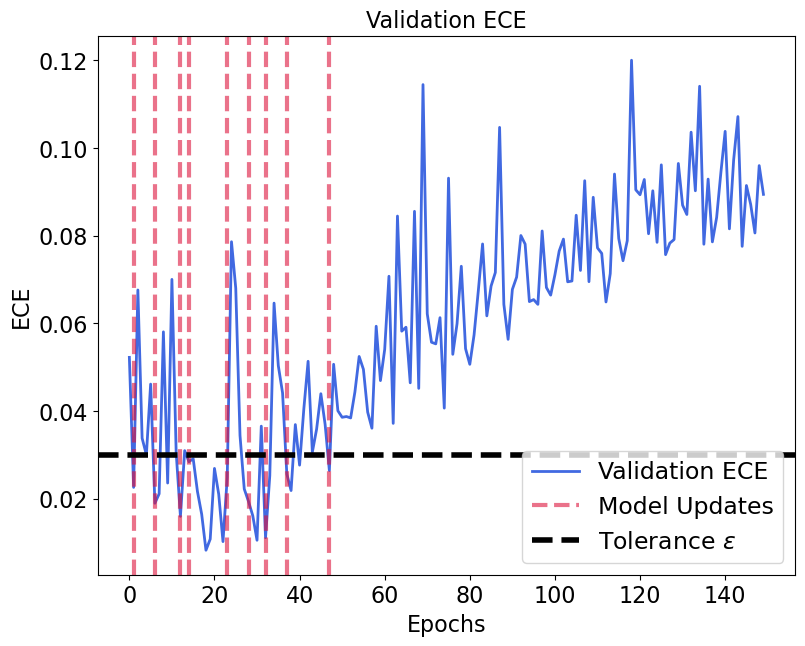

In [7]:
epsilon = 0.03
epochs = data['epoch_controlled']
va_ece_list = data['va_ece_list']
va_sharp_list = data['va_sharp_list']
epoch_of_updates = []
# we update epoch when ece is smaller than epsilon, and sharpness is smaller than previous best
best_sharp = float('inf')
max_epoch = 150
for epoch, (ece, sharp) in enumerate(zip(va_ece_list[:max_epoch], va_sharp_list[:max_epoch])):
    if ece < epsilon and sharp < best_sharp:
        epoch_of_updates.append(epoch)
        best_sharp = sharp
print(f"Epochs of updates: {epoch_of_updates}")
# plot the epoch vs ece curve, and mark the update epochs with dashed vertical lines. Also use horizontal line to mark epsilon
plt.figure(figsize=(9, 7))
plt.plot(va_ece_list[:max_epoch], label='Validation ECE', linewidth=2, color='royalblue')
for epoch in epoch_of_updates:
    plt.axvline(x=epoch, color='crimson', linestyle='--', label='Model Updates' if epoch == epoch_of_updates[0] else "", alpha=0.6, linewidth=3)
plt.axhline(y=epsilon, color='black', linestyle='--', label='Tolerance $\epsilon$', alpha=1, linewidth=4)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('ECE', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('Validation ECE', fontsize=16)
plt.legend(fontsize=17, framealpha=0.8)
plt.savefig('protein_model_update_ece.pdf')


Epochs of updates: [1, 6, 12, 14, 23, 28, 32, 37, 47]


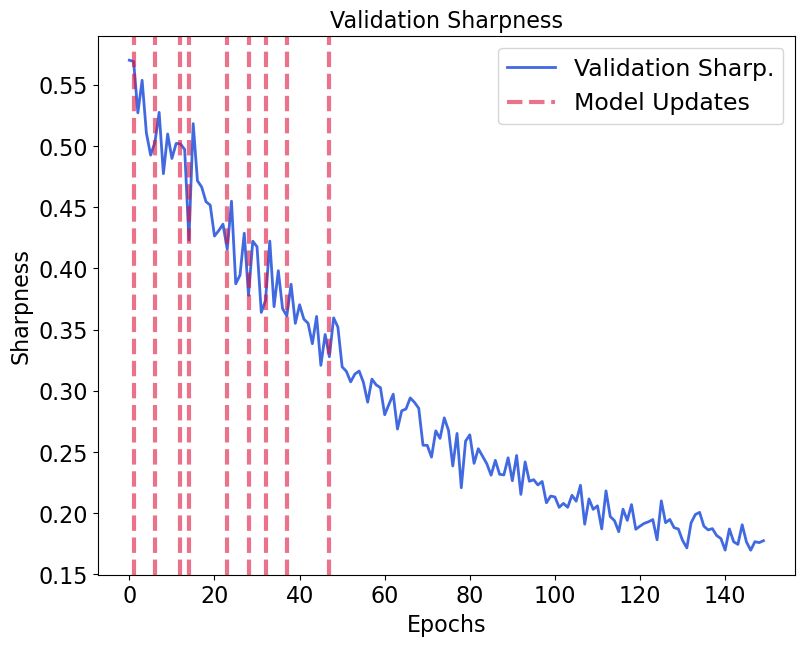

In [8]:
epsilon = 0.03
epochs = data['epoch_controlled']
va_ece_list = data['va_ece_list']
va_sharp_list = data['va_sharp_list']
epoch_of_updates = []
# we update epoch when ece is smaller than epsilon, and sharpness is smaller than previous best
best_sharp = float('inf')
max_epoch = 150
for epoch, (ece, sharp) in enumerate(zip(va_ece_list[:max_epoch], va_sharp_list[:max_epoch])):
    if ece < epsilon and sharp < best_sharp:
        epoch_of_updates.append(epoch)
        best_sharp = sharp
print(f"Epochs of updates: {epoch_of_updates}")
# plot the epoch vs ece curve, and mark the update epochs with dashed vertical lines. Also use horizontal line to mark epsilon
plt.figure(figsize=(9, 7))
plt.plot(va_sharp_list[:max_epoch], label='Validation Sharp.', linewidth=2, color='royalblue')
for epoch in epoch_of_updates:
    plt.axvline(x=epoch, color='crimson', linestyle='--', label='Model Updates' if epoch == epoch_of_updates[0] else "", alpha=0.6, linewidth=3)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Sharpness', fontsize=16)
plt.title('Validation Sharpness', fontsize=16)
plt.legend(fontsize=17, framealpha=0.8)
plt.savefig('protein_model_update_sharpness.pdf')


Method: batch_qr, Best Epoch: 7, ECE: 0.04548061266541481, Sharpness: 0.011939732568005377
Plotted for epsilon 0.05, dataset yacht, seed 1
Method: batch_cal, Best Epoch: 0, ECE: 0.04670576751232147, Sharpness: 0.09703830241219968
Plotted for epsilon 0.05, dataset yacht, seed 1
Method: batch_int, Best Epoch: 5, ECE: 0.11506679654121399, Sharpness: 0.02641555275310905
Plotted for epsilon 0.05, dataset yacht, seed 1
Method: maqr, Best Epoch: 2, ECE: 0.07538612186908722, Sharpness: 0.011526003562637655
Plotted for epsilon 0.05, dataset yacht, seed 1
Method: calipso, Best Epoch: 2, ECE: 0.107846200466156, Sharpness: 0.021409848397201406
Plotted for epsilon 0.05, dataset yacht, seed 1
Method: dheur, Best Epoch: 5, ECE: 0.10256759822368622, Sharpness: 0.015154639335104142
Plotted for epsilon 0.05, dataset yacht, seed 1


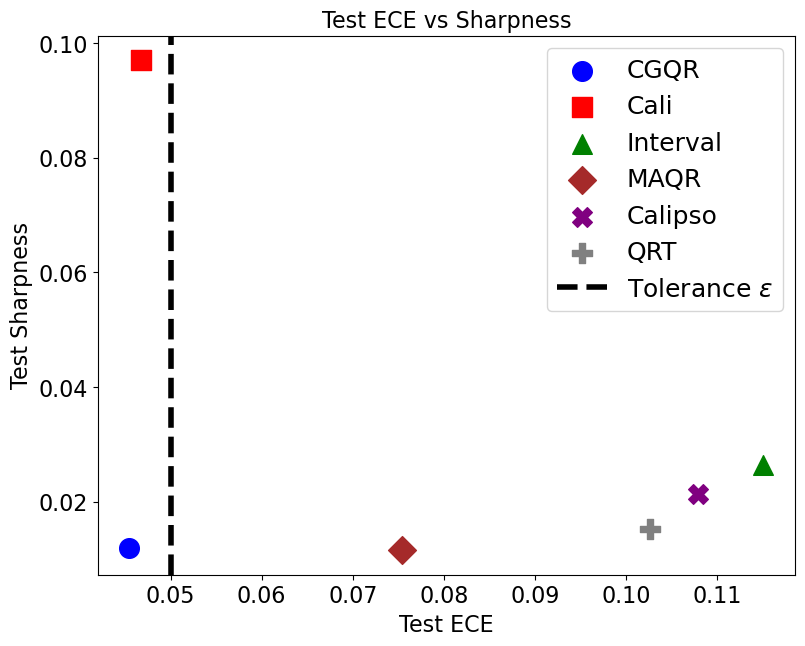

In [ ]:
# pick the best model based on the largest ece smaller than epsilon with the smallest sharpness for every method
# and scatter plot
def find_method_name(pkl_name):
    if 'batch_qr' in pkl_name:
        return 'batch_qr'
    elif 'batch_cal' in pkl_name:
        return 'batch_cal'
    elif 'batch_int' in pkl_name:
        return 'batch_int'
    elif 'maqr' in pkl_name:
        return 'maqr'
    elif 'calipso' in pkl_name:
        return 'calipso'
    elif 'QRT' in pkl_name:
        return 'dheur'
    else:
        return 'unknown'
from plots.plot_utils import METHOD_COLORS, METHOD_MARKERS, TITLE_METHODS
import numpy as np
from glob import glob
import os
from plots.plot_utils import load_pickle
import matplotlib.pyplot as plt
# for seed in range(2):
    # for dataset in ['boston', 'concrete', 'energy', 'naval', 'protein', 'yacht', 'kin8nm', 'power', 'wine']:
seed = 1
dataset = 'yacht'
epsilon = 0.05
order = {'batch_qr': 0, 'batch_cal': 1, 'batch_int': 2, 'maqr': 3, 'calipso': 4, 'dheur': 5}
all_baseline_pkls = glob(os.path.join(os.environ['SCRATCH'], 'results', 'lump', dataset, 'nl-8_hs-256', f'*nl8_hs256*_{seed}.pkl'))
all_baseline_pkls = sorted(all_baseline_pkls, key=lambda x: order.get(find_method_name(x), 100))
all_baseline_data = [load_pickle(pkl) for pkl in all_baseline_pkls]
names = [find_method_name(pkl) for pkl in all_baseline_pkls]
        # for epsilon in np.arange(0.01, 0.051, 0.005):
plt.figure(figsize=(9, 7))
for idx, data in enumerate(all_baseline_data):
    va_ece_controlled = data['va_ece_controlled']
    va_sharp_score_controlled = data['va_sharp_score_controlled']
    te_ece_controlled = data['te_ece_controlled']
    te_sharp_score_controlled = data['te_sharp_score_controlled']

    # find the best model
    method = names[idx]
    best_epoch = -1
    best_va_ece = float('inf')
    best_va_sharp = float('inf')
    best_te_ece = float('inf')
    best_te_sharp = float('inf')
    for epoch, (va_ece, va_sharp, te_ece, te_sharp) in enumerate(zip(va_ece_controlled, va_sharp_score_controlled, te_ece_controlled, te_sharp_score_controlled)):
        if va_ece < epsilon and va_sharp < best_va_sharp:
            best_epoch = epoch
            best_va_sharp = va_sharp
            best_va_ece = va_ece
            best_te_sharp = te_sharp
            best_te_ece = te_ece
    print(f"Method: {method}, Best Epoch: {best_epoch}, ECE: {best_te_ece}, Sharpness: {best_te_sharp}")
    if best_epoch == -1:
        print(f"No model found for method {method} with epsilon {epsilon}")
        continue
    plt.scatter(best_te_ece, best_te_sharp, label=TITLE_METHODS[method], marker=METHOD_MARKERS.get(method, 'o'), color=METHOD_COLORS.get(method, 'black'), s=200)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.xlabel('Test ECE', fontsize=16)
    plt.ylabel('Test Sharpness', fontsize=16)
    plt.title(f'Test ECE vs Sharpness', fontsize=16)
    print(f"Plotted for epsilon {epsilon}, dataset {dataset}, seed {seed}")
plt.axvline(epsilon, color='black', linestyle='--', label='Tolerance $\epsilon$', linewidth=4)
plt.legend(fontsize=18)
plt.savefig(f'illustration_test_ece_sharpness_scatter.pdf')
plt.show()
plt.close()




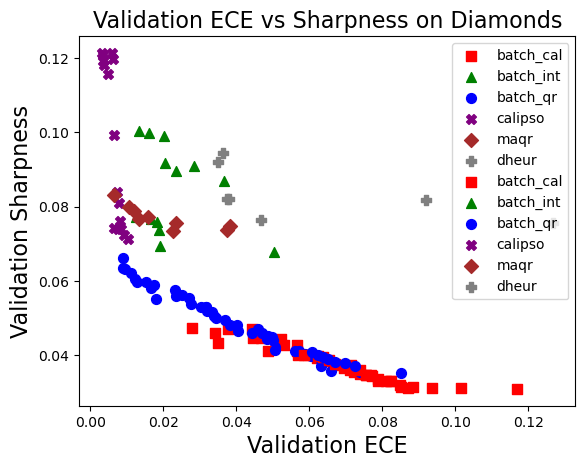

In [ ]:
from glob import glob
import os
from plots.plot_utils import load_pickle
import matplotlib.pyplot as plt
def find_method_name(pkl_name):
    if 'batch_qr' in pkl_name:
        return 'batch_qr'
    elif 'batch_cal' in pkl_name:
        return 'batch_cal'
    elif 'batch_int' in pkl_name:
        return 'batch_int'
    elif 'maqr' in pkl_name:
        return 'maqr'
    elif 'calipso' in pkl_name:
        return 'calipso'
    elif 'QRT' in pkl_name:
        return 'dheur'
    else:
        return 'unknown'
from plots.plot_utils import METHOD_COLORS, METHOD_MARKERS, TITLE_METHODS
import numpy as np
seeds = [0, 1]
all_baselines_pkls = []
dataset = 'diamonds'
for seed in seeds:
    all_baselines_pkls += glob(os.path.join(os.environ['SCRATCH'], 'results', 'lump', dataset, 'nl-8_hs-256', f'{dataset}*nl8_hs256_{seed}.pkl'))
for pkl in all_baselines_pkls:
    data = load_pickle(pkl)
    va_ece_list = data['va_ece_controlled']
    va_sharp_list = data['va_sharp_score_controlled']
    # find the best model
    method = find_method_name(pkl)
    plt.scatter(va_ece_list, va_sharp_list, label=method, marker=METHOD_MARKERS.get(method, 'o'), color=METHOD_COLORS.get(method, 'black'), s=50)
plt.xlabel('Validation ECE', fontsize=16)
plt.ylabel('Validation Sharpness', fontsize=16)
plt.title(f'Validation ECE vs Sharpness', fontsize=16)
plt.legend(fontsize=16)

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from plots.plot_utils import COLORS, BASELINE_NAMES, METHOD_COLORS, TITLE_METHODS, METHOD_MARKERS

# 1. Create a figure and an axes object.
fig, ax = plt.subplots(figsize=(10, 1))

# 2. Create the "handles" for the legend using Line2D for dots.
#    - We create dummy Line2D objects that have no visible line ('linestyle="None"').
#    - We set the marker to 'o' for a circle (dot).
#    - We increase the markersize for better visibility.
legend_handles = [
    Line2D([0], [0], 
           marker= METHOD_MARKERS[name],
           color=METHOD_COLORS[name], 
           label=TITLE_METHODS[name],
           linestyle='None',
           markersize=16)  # 'medium' size dot
    for name in BASELINE_NAMES
]

# 3. Create the legend with the new dot handles.
#    The parameters for the legend function remain the same.
ax.legend(
    handles=legend_handles,
    ncol=len(BASELINE_NAMES),
    loc='center',
    fontsize='large',
    frameon=False
)

# 4. Clean up the plot by turning off the axis.
ax.axis('off')

# 5. Adjust layout and show/save the figure.
plt.tight_layout()
plt.savefig("method_legend_dots_large.pdf", dpi=300, bbox_inches='tight')
plt.show()

print("Legend with dots has been generated and displayed.")